In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from colormath.color_objects import LabColor, LuvColor, XYZColor, sRGBColor, HSVColor, LCHabColor, LCHuvColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000 as De

# vectorized version
def hsv_to_rgb_v( h, s, v) -> tuple:
    
    out = np.full([h.shape[0],3], np.nan)
    idx_na = np.isnan(h) | np.isnan(s) | np.isnan(v)
    out[idx_na,:] = np.array([1,1,1]).T

    out_tmp = np.full([np.sum(~idx_na),3], np.nan)
    h = h[~idx_na]
    s = s[~idx_na]
    v = v[~idx_na]

    h[h==1.0] = 0.0
    i = (h*6.0).astype(int)
    f = h*6.0 - i
        
    w = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i[s==0] = -1

    out_tmp[i==0,:] = np.array([v[i==0],t[i==0],w[i==0]]).T
    out_tmp[i==1,:] = np.array([q[i==1],v[i==1],w[i==1]]).T
    out_tmp[i==2,:] = np.array([w[i==2],v[i==2],t[i==2]]).T
    out_tmp[i==3,:] = np.array([w[i==3],q[i==3],v[i==3]]).T
    out_tmp[i==4,:] = np.array([t[i==4],w[i==4],v[i==4]]).T
    out_tmp[i==5,:] = np.array([v[i==5],w[i==5],q[i==5]]).T
    out_tmp[i==-1,:] = np.array([v[i==-1],v[i==-1],v[i==-1]]).T

    out[~idx_na,:] = out_tmp

    
    return out

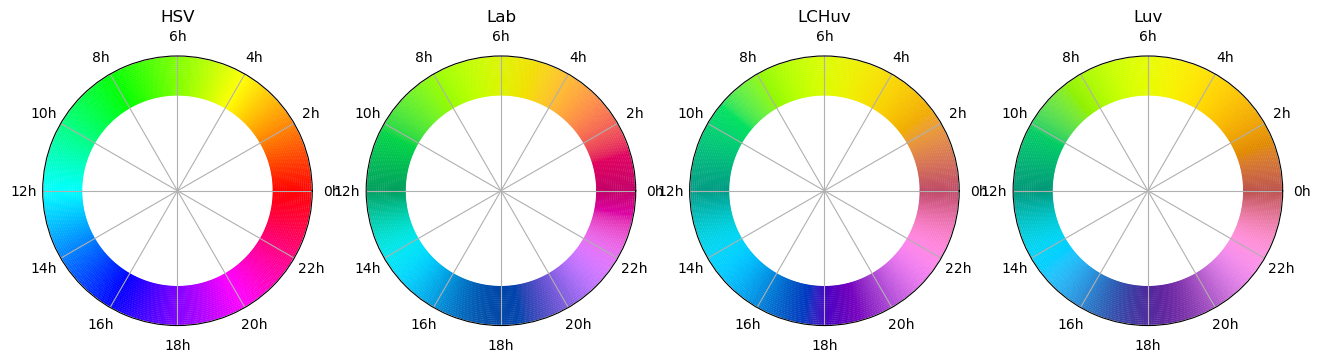

In [114]:
n = 512
φ = np.linspace(0,2*np.pi,n)
r = np.ones(n)

# plot hsv colors in polar coordinates
h = φ/(2*np.pi)
s = r/r.max()
v = np.ones(n)
hsv = hsv_to_rgb_v(h,s,v)

a = (np.cos(φ))*90 + 10
b = (np.sin(φ))*80 + 20
#L = 65+(np.cos(2*(φ-np.pi/4))+1)/2*30
C = np.ones(n)*100
H = h*360
L = np.ones(n)*50
idx = np.sin(φ)>0
L[idx] = 53+np.sin(φ[idx])*45
L[~idx] = 53-np.sin(3*φ[~idx])*25

lab = np.zeros([n,3])
lchuv = np.zeros([n,3])
luv = np.zeros([n,3])
DE = []
for i in range(n):
    col = convert_color(LabColor(lab_l=L[i],lab_a=a[i],lab_b=b[i],observer='10', illuminant='d65'),sRGBColor)
    #col = convert_color(LCHabColor(lch_l=L[i],lch_c=C[i],lch_h=H[i],observer='2', illuminant='d65'),sRGBColor)
    lab[i,:] = np.array(col.get_value_tuple())
    #Lab.append(LabColor(lab_l=L[i],lab_a=a[i],lab_b=b[i],observer='2', illuminant='d65'))
    col = convert_color(LCHuvColor(lch_l=L[i],lch_c=C[i],lch_h=H[i]),sRGBColor)
    lchuv[i,:] = np.array(col.get_value_tuple())

    col = convert_color(LuvColor(luv_l=L[i],luv_u=a[i],luv_v=b[i]),sRGBColor)
    luv[i,:] = np.array(col.get_value_tuple())

lab = lab/lab.max(axis=0)
lchuv /= lchuv.max(axis=0)
luv /= luv.max(axis=0)

COLORS = [hsv,lab,lchuv,luv]

fig,axes = plt.subplots(1,len(COLORS),figsize=(4*len(COLORS),4),subplot_kw=dict(projection='polar'))
for c, color in enumerate(COLORS):


    ax = axes[c]
    for shift in np.arange(0,0.4,0.02):
        ax.scatter(x=φ,y=r+shift,c=color,s=.5,marker='o',rasterized=True)
    ax.grid('off')
    ax.yaxis.set_visible(False)

    ax.set_xticks(np.linspace(0,2*np.pi,13)[:-1],[f'{t}h' for t in np.linspace(0,24,13)[:-1].astype(int)])
    #ax.set_theta_zero_location("N")  # theta=0 at the top
    #ax.set_theta_direction(-1)  # theta increasing clockwise

    ax.set_title(['HSV','Lab','LCHuv','Luv'][c])



In [112]:
print('red:', convert_color(sRGBColor(1,0,0),LabColor) )
print('yellow:', convert_color(sRGBColor(1,1,0),LabColor) )
print('green:', convert_color(sRGBColor(0,1,0),LabColor) )
print('blue:', convert_color(sRGBColor(0,0,1),LabColor) )
hsv[128*3,:]
print('purple:', convert_color(sRGBColor(.5,0,1),LabColor) )

red: LabColor (lab_l:53.2390 lab_a:80.0905 lab_b:67.2014)
yellow: LabColor (lab_l:97.1388 lab_a:-21.5578 lab_b:94.4773)
green: LabColor (lab_l:87.7350 lab_a:-86.1829 lab_b:83.1795)
blue: LabColor (lab_l:32.2994 lab_a:79.1914 lab_b:-107.8655)
purple: LabColor (lab_l:40.8487 lab_a:83.1344 lab_b:-93.4023)


In [113]:
a[3*128]

10.829958898040193